In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import copy

import ase.io

from equistore import TensorBlock, TensorMap, Labels

from utils.models.soap import compute_power_spectrum
from rascaline import SphericalExpansion

In [3]:
frames = ase.io.read("data/molecule_conformers_dftb.xyz", ":100")

# frames = ase.io.read("selection-10k.extxyz", "::100")
for frame in frames:
    frame.pbc = [False, False, False]
    frame.cell = [0, 0, 0]
    # frame.cell = [100, 100, 100]
    # frame.center()

training_frames, testing_frames = sklearn.model_selection.train_test_split(
    frames, train_size=0.8, random_state=0XDEADBEEF, 
)


train_energies = np.array([
    frame.info["energy"] for frame in training_frames
])

train_forces = np.vstack([
    frame.arrays["forces"] for frame in training_frames
])

test_energies = np.array([
    frame.info["energy"] for frame in testing_frames
])

test_forces = np.vstack([
    frame.arrays["forces"] for frame in testing_frames
])

In [4]:
RASCAL_HYPERS = {
    "interaction_cutoff": 3.5,
    "cutoff_smooth_width": 0.5,
    "max_radial": 6,
    "max_angular": 6,
    "gaussian_sigma_type": "Constant",
    "gaussian_sigma_constant": 0.3,
}

# def compute_spherical_expansion(frames, gradients=False):
#     hypers = copy.deepcopy(RASCAL_HYPERS)
#     hypers["compute_gradients"] = gradients
    
#     calculator = RascalSphericalExpansion(hypers)
#     return calculator.compute(frames)

RASCALINE_HYPERS = {
    "cutoff": RASCAL_HYPERS["interaction_cutoff"],
    "atomic_gaussian_width": RASCAL_HYPERS["gaussian_sigma_constant"],
    "max_radial": RASCAL_HYPERS["max_radial"],
    "max_angular": RASCAL_HYPERS["max_angular"],
    "radial_basis": {"Gto": {}},
    "cutoff_function": {"ShiftedCosine": {"width": RASCAL_HYPERS["cutoff_smooth_width"]}},
    "center_atom_weight": 1.0,
}

TRAIN_WITH_FORCES = False

def selected_samples(frames, hypers):
    """Create a list of selected samples so that all blocks have the same set 
    of samples for simpler implementation of compute_power_spectrum"""
    if not isinstance(frames, list):
        frames = [frames]
        
    all_species = set()
    for frame in frames:
        all_species.update(frame.numbers)

    keys = Labels(
        names=["spherical_harmonics_l", "species_center", "species_neighbor"],
        values=np.array([
            [l, s_c, s_n] 
            for l in range(hypers["max_angular"] + 1)
            for s_c in all_species
            for s_n in all_species
        ], dtype=np.int32)
    )
    blocks = []
    for _ in range(len(keys)):
        samples = Labels(
            names=["structure", "center"],
            values=np.array([
                [s, c] 
                for s in range(len(frames))
                for c in range(len(frames[s]))
            ], dtype=np.int32)
        )
        
        blocks.append(TensorBlock(
            values=np.empty((len(samples), 1)),
            samples=samples, 
            components=[],
            properties=Labels.single()
        ))
        
    return TensorMap(keys, blocks)

def compute_spherical_expansion(frames, gradients=False):
    hypers = copy.deepcopy(RASCALINE_HYPERS)
    hypers["gradients"] = gradients
    
    calculator = SphericalExpansion(**hypers)
    return calculator.compute(frames, selected_samples=selected_samples(frames, hypers))

# Training models

In [5]:
def rmse(actual, predicted):
    return np.sqrt(np.mean((actual.flatten() - predicted.flatten())**2))

def parity_plot(energies, predicted_energies, forces, predicted_forces):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    loss = rmse(energies, predicted_energies)
    x = [energies.min(), energies.max()]
    ax[0].plot(x, x, color="r")
    ax[0].scatter(energies, predicted_energies)
    ax[0].set_title(f"Energy — RMSE = {1000 * loss:.4} meV")

    loss = rmse(forces.flatten(), predicted_forces.flatten())
    x = [forces.flatten().min(), forces.flatten().max()]
    ax[1].plot(x, x, color="r")
    ax[1].scatter(forces.flatten(), predicted_forces.flatten())
    ax[1].set_title(f"Forces — RMSE = {1000 * loss:.5} meV/A")

In [6]:
def check_finite_differences(model, frame, delta=1e-6, keys_to_samples=True):
    frame = frame.copy()

    spx = compute_spherical_expansion(frame, gradients=True)
    ps = compute_power_spectrum(spx)
    ps.keys_to_properties(['species_neighbor_1', 'species_neighbor_2'])
    if keys_to_samples:
        ps.keys_to_samples('species_center')
    energy, forces = model.predict(ps, with_forces=True)

    frame.positions[3, 1] += delta
    spx_delta = compute_spherical_expansion(frame, gradients=True)
    ps_delta = compute_power_spectrum(spx_delta)
    ps_delta.keys_to_properties(['species_neighbor_1', 'species_neighbor_2'])
    if keys_to_samples: 
        ps_delta.keys_to_samples('species_center')

    energy_delta, _ = model.predict(ps_delta, with_forces=True)

    finite_diff = - (energy_delta[0, 0] - energy[0, 0]) / delta
    print("finite difference =", finite_diff)
    print("computed gradient =", forces[3, 1])

In [7]:
train_spx = compute_spherical_expansion(training_frames, gradients=True)
train_ps = compute_power_spectrum(train_spx)
train_ps.keys_to_properties(['species_neighbor_1', 'species_neighbor_2'])
train_ps.keys_to_samples('species_center')


test_spx = compute_spherical_expansion(testing_frames, gradients=True)
test_ps = compute_power_spectrum(test_spx)
test_ps.keys_to_properties(['species_neighbor_1', 'species_neighbor_2'])
test_ps.keys_to_samples('species_center')


train_spx_no_grad = compute_spherical_expansion(training_frames, gradients=False)
train_ps_no_grad = compute_power_spectrum(train_spx_no_grad)
train_ps_no_grad.keys_to_properties(['species_neighbor_1', 'species_neighbor_2'])
train_ps_no_grad.keys_to_samples('species_center')

## Train a linear regression model

In [8]:
from utils.models.linear import LinearModel

In [9]:
model = LinearModel(normalize=True, regularizer=[1e-4, 5e-4])

if TRAIN_WITH_FORCES:
    model.fit(train_ps, train_energies, train_forces)
else:
    model.fit(train_ps_no_grad, train_energies)

In [10]:
check_finite_differences(model, testing_frames[0], delta=1e-5)

finite difference = -0.14137986568130145
computed gradient = -0.141237480943815


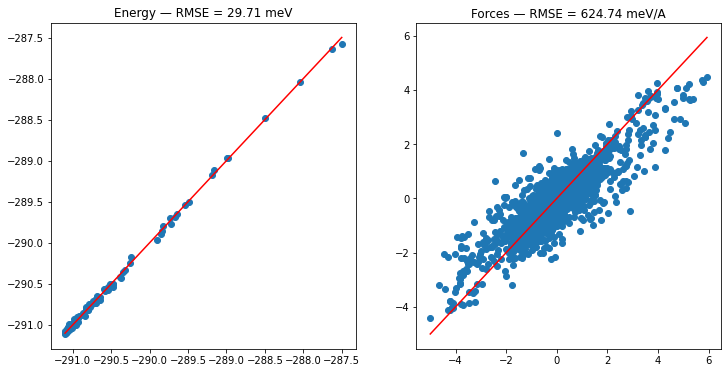

In [11]:
predicted_e, predicted_f = model.predict(train_ps, with_forces=True)

parity_plot(train_energies, predicted_e, train_forces, predicted_f)

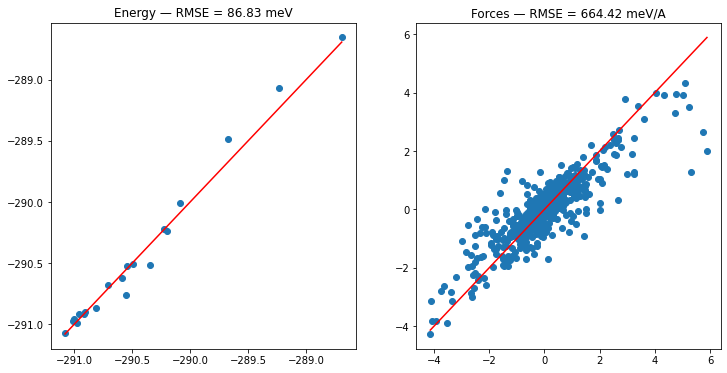

In [12]:
predicted_e, predicted_f = model.predict(test_ps, with_forces=True)

parity_plot(test_energies, predicted_e, test_forces, predicted_f)

## Train a GAP model with full kernel

In [13]:
from utils.models.full_kernel import FullKernelGap

In [14]:
model = FullKernelGap(zeta=2, regularizer=[1e-2, 1e-2])

if TRAIN_WITH_FORCES:
    print("can not train full kernel with forces yet")

model.fit(train_ps_no_grad, train_energies)

In [15]:
check_finite_differences(model, testing_frames[0], delta=1e-6)

finite difference = 0.09763340358404093
computed gradient = 0.09764744955039228


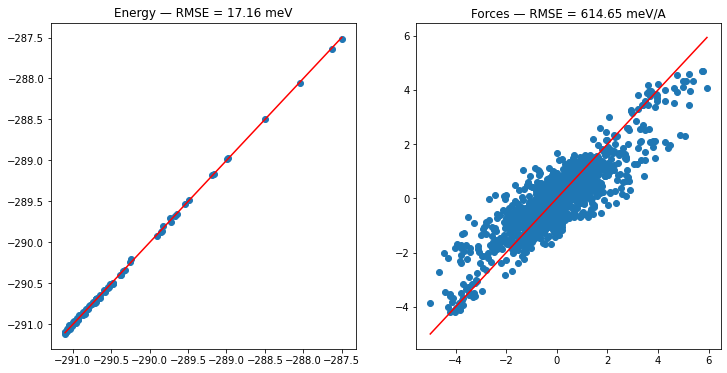

In [16]:
predicted_e, predicted_f = model.predict(train_ps, with_forces=True)

parity_plot(train_energies, predicted_e, train_forces, predicted_f)

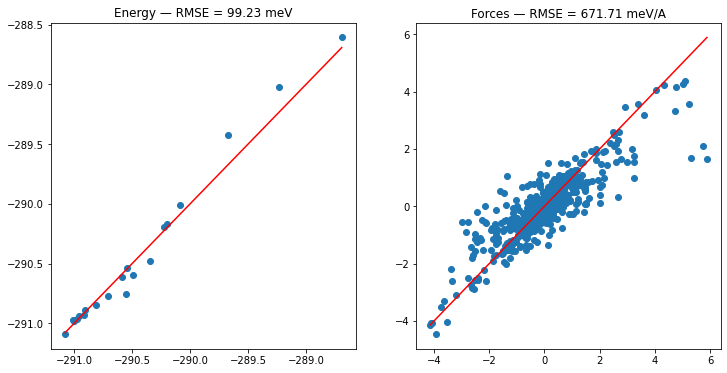

In [17]:
predicted_e, predicted_f = model.predict(test_ps, with_forces=True)

parity_plot(test_energies, predicted_e, test_forces, predicted_f)

## Sparse kernels

In [18]:
from utils.models.sparse_kernel import select_support_points, SparseKernelGap

In [19]:
support = select_support_points(train_ps, n_select=80)

print(support.block().values.shape)

TypeError: __init__() got an unexpected keyword argument 'score_threshold_type'

In [ ]:
model = SparseKernelGap(support_points=support, zeta=1, regularizer=[1e-2, 5e-2])

if TRAIN_WITH_FORCES:
    model.fit(train_ps, train_energies, train_forces)
else:
    model.fit(train_ps_no_grad, train_energies)

In [ ]:
check_finite_differences(model, testing_frames[0], delta=1e-6)

In [ ]:
predicted_e, predicted_f = model.predict(train_ps, with_forces=True)

parity_plot(train_energies, predicted_e, train_forces, predicted_f)

In [ ]:
predicted_e, predicted_f = model.predict(test_ps, with_forces=True)

parity_plot(test_energies, predicted_e, test_forces, predicted_f)

## Sparse kernel with different support point per central species

In [ ]:
train_ps_per_species = compute_power_spectrum(train_spx)
train_ps_per_species.keys_to_properties(['species_neighbor_1', 'species_neighbor_2'])

train_ps_per_species_no_grad = compute_power_spectrum(train_spx_no_grad)
train_ps_per_species_no_grad.keys_to_properties(['species_neighbor_1', 'species_neighbor_2'])

test_ps_per_species = compute_power_spectrum(test_spx)
test_ps_per_species.keys_to_properties(['species_neighbor_1', 'species_neighbor_2'])

In [ ]:
n_select = {
    species_center: 0
    for species_center in train_ps_per_species.keys.as_namedtuples()
}

n_select[(1,)] = 30
n_select[(6,)] = 30
n_select[(8,)] = 20

support = select_support_points(train_ps_per_species, n_select=n_select)

In [ ]:
model = SparseKernelGap(support_points=support, zeta=2, regularizer=[1e-2, 1e-2])

if TRAIN_WITH_FORCES:
    model.fit(train_ps_per_species, train_energies, train_forces)
else:
    model.fit(train_ps_per_species_no_grad, train_energies)

In [ ]:
check_finite_differences(model, testing_frames[0], delta=1e-6, keys_to_samples=False)

In [ ]:
predicted_e, predicted_f = model.predict(train_ps_per_species, with_forces=True)

parity_plot(train_energies, predicted_e, train_forces, predicted_f)

In [ ]:
predicted_e, predicted_f = model.predict(test_ps_per_species, with_forces=True)

parity_plot(test_energies, predicted_e, test_forces, predicted_f)